In [1]:
!pip install networkx

# Graph Construction

In [2]:
import pandas as pd
import networkx as nx
import numpy as np

In [3]:
df = pd.read_excel("SFHH1.xlsx")

In [4]:
G = nx.Graph()

In [5]:
edges = df[["node1", "node2"]].drop_duplicates().values.tolist()

In [6]:
G.add_edges_from(edges)

## Question 1

In [8]:
N = G.number_of_nodes() 
print("Number of Nodes: ", N)

Number of Nodes:  403


In [9]:
E = G.number_of_edges()
print("Number of Edges: ", E)

Number of Edges:  9510


In [10]:
degrees = []
for node, degree in G.degree():
    degrees.append(degree)

In [11]:
avg_degree = np.mean(degrees).round(2)
std_degree = np.std(degrees).round(2)
print("Average Degree: ", avg_degree)
print("Standard Deviation of Degrees: ", std_degree)

Average Degree:  47.2
Standard Deviation of Degrees:  29.95


## Question 2

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# sns.set_style(style = "dark")
sns.set_style("dark")
sns.set_palette("bone")

Text(0.5, 1.0, 'Degree Distribution')

Text(0.5, 1.0, 'Degree Distribution')

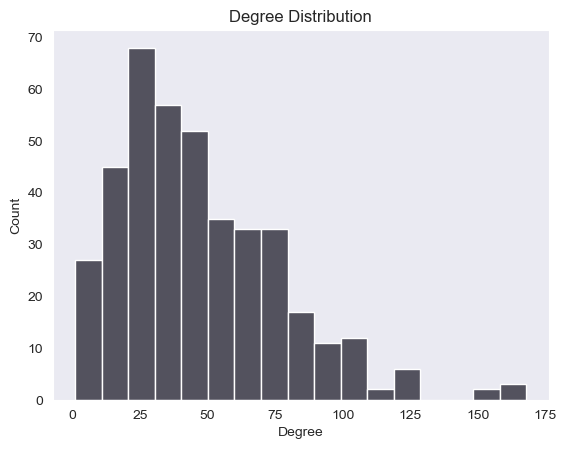

In [15]:
d_viz = sns.histplot(degrees)
d_viz.set_xlabel('Degree')
d_viz.set_ylabel('Count')
d_viz.set_title('Degree Distribution')

## Question 3

In [17]:
rho_D = nx.degree_assortativity_coefficient(G)
print("Degree assortativity: ", rho_D)

Degree assortativity:  -0.08001195267658665


## Question 4

In [19]:
C = nx.average_clustering(G)
print("Clustering coefficient: ", C)

Clustering coefficient:  0.27752342886036674


## Question 5

In [21]:
Eh = nx.average_shortest_path_length(G)
Hmax = nx.diameter(G)
print("Average Hopcount: ", Eh)
print("Diameter of Graph: ", Hmax)

Average Hopcount:  1.955211535375233
Diameter of Graph:  4


## Question 7

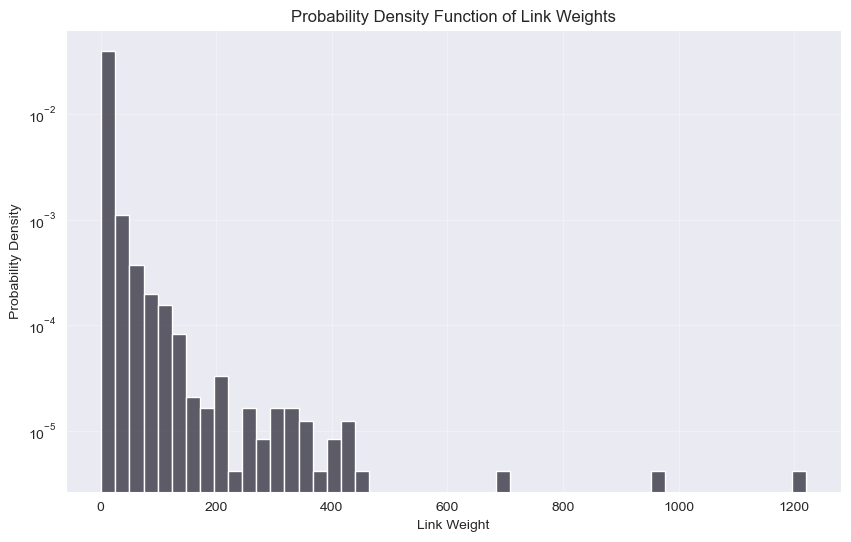

In [26]:

link_weights = df.groupby(['node1', 'node2']).size().values

plt.figure(figsize=(10, 6))
sns.histplot(link_weights, bins=50, stat='density', alpha=0.7)
plt.xlabel('Link Weight')
plt.ylabel('Probability Density')
plt.title('Probability Density Function of Link Weights')
plt.yscale('log') 
plt.grid(True, alpha=0.3)
plt.show()